# Fine-tuning LoRA's

LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning technique for large language models.  
Instead of updating all model parameters during fine-tuning (which can be billions), LoRA adds small trainable "rank decomposition" matrices to key layers.  
For example, in a 8B parameter model like Llama 3, we might only train 1-2% of parameters using LoRA.


Real-world example:  
If you want to adapt GPT to be better at biology questions, retraining all parameters is expensive.  
LoRA lets you inject small, trainable matrices into attention layers.  
These matrices learn to "steer" the model's existing knowledge toward biology, while keeping most original parameters frozen.  

This makes fine-tuning much more efficient in terms of:
- Computing requirements (can run on consumer GPUs)
- Memory usage (don't need to store full parameter copies)
- Training time (fewer parameters to optimize)

### Rank Decomposition
Rank decomposition in LoRA works by breaking down a large weight update matrix into two smaller matrices that, when multiplied together, approximate the desired weight changes.  

Here's how it works:
1. Traditional Fine-tuning  
    - Training:  
        `Original weight matrix W (e.g., 512×512)`  
        ↓  
        `Full update matrix ΔW (512×512) is learned`  
        Learning 262,144 parameters  

    - Inference:  
        `Output = W × input`
    
        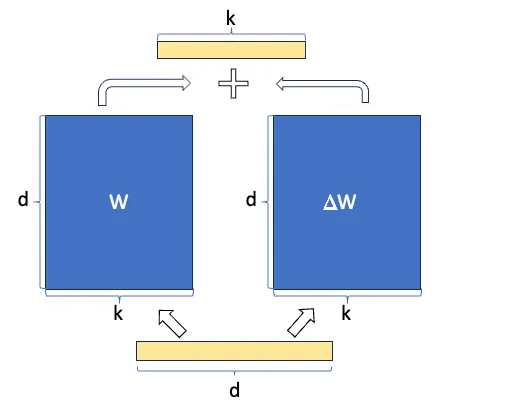

2. LoRA's Approach  
    - Training:  
        `Learn A (512×r) and B (r×512) where r is small (e.g., 8, 16, 32)`  
        ↓  
        `ΔW ≈ A × B (approximation of ΔW learned)`  
        For r = 16, A is 512×16 (8,192 parameters), B is 16×512 (8,192 parameters), totaling 16,384 parameters  
        
    - Inference:  
        `Output = W × input + α(A × B) × input`  
        Where α is a scaling factor (usually equal to r)   

        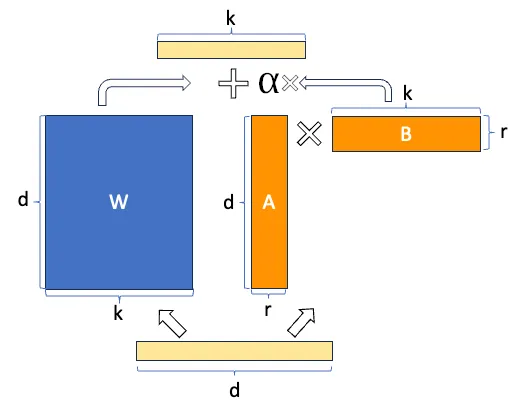

In [1]:
!pip install -q transformers datasets torch unsloth ipywidgets scikit-learn numpy plotly pandas hf_transfer
import os
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Setup model

We will be using the `unsloth/Llama-3.2-3B-Instruct` model.

Unsloth is a library that allows us to load models efficiently and train LoRA efficiently.

Here are a few models compatible with Unsloth:
- `unsloth/Meta-Llama-3.1-8B`      
- `unsloth/Meta-Llama-3.1-8B-Instruct`
- `unsloth/Meta-Llama-3.1-70B`
- `unsloth/Meta-Llama-3.1-405B`    
- `unsloth/Mistral-Nemo-Base-2407` 
- `unsloth/Mistral-Nemo-Instruct-2407`
- `unsloth/mistral-7b-v0.3`       
- `unsloth/mistral-7b-instruct-v0.3`
- `unsloth/Phi-3.5-mini-instruct`  
- `unsloth/Phi-3-medium-4k-instruct`
- `unsloth/gemma-2-9b`
- `unsloth/gemma-2-27b`       

You can find more models at https://huggingface.co/unsloth.

In [2]:
from unsloth import FastLanguageModel
import torch

# max context length
max_seq_length = 2048

dtype = None # auto

# load in 4bit or 8bit if the model doesn't fit on your GPU
load_in_4bit = False
load_in_8bit = False

# set a random seed for reproducibility
random_state = 42

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    load_in_8bit = load_in_8bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.546 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Setup dataset

We will be fine-tuning on the [RoBiology/RoBiologyDataChoiceQA](https://huggingface.co/datasets/RoBiology/RoBiologyDataChoiceQA) dataset.

This fine-tune will only use single-choice questions.

Load the dataset:

In [3]:
from datasets import load_dataset

dataset = load_dataset("RoBiology/RoBiologyDataChoiceQA")
dataset

DatasetDict({
    train: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 11368
    })
    validation: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 1376
    })
    test: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 1388
    })
})

Filter for single-choice questions:

In [4]:
train_ds = dataset['train'].filter(lambda x: x['type'] == 'single-choice')
validation_ds = dataset['validation'].filter(lambda x: x['type'] == 'single-choice')

train_ds

Dataset({
    features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
    num_rows: 4860
})

Generate chat prompts:

In [5]:
def create_chat_prompt(instruction: str, input: str, response: str|None = None):
    return tokenizer.apply_chat_template(
        [
            {"role": "system", "content": instruction},
            {"role": "user", "content": input},
            *([{"role": "assistant", "content": response}] if response else []),
        ],
        tokenize=False,
    )


In [6]:
instuction = "Answer the question based on the given options. Respond by writing only the letter of the correct answer."

print(create_chat_prompt(
    instuction,
    "\n".join([train_ds[0]["question"]] + train_ds[0]["options"]),
    train_ds[0]["right_answer"],
))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 07 Dec 2024

Answer the question based on the given options. Respond by writing only the letter of the correct answer.<|eot_id|><|start_header_id|>user<|end_header_id|>

Celula procariotă:
A. caracterizea ză virusurile, bacteriile și algele alba stre verzi
B. conține pept idioglican în compoziția membranei celulare
C. nu prezintă perete celular
D. materialul nuclear este o moleculă circulară de ADN bicatenar<|eot_id|><|start_header_id|>assistant<|end_header_id|>

D<|eot_id|>


In [7]:
train = train_ds.map(lambda x: {
    "chat": create_chat_prompt(instuction, '\n'.join([x['question']] + x['options']), x['right_answer']) 
})

validation = validation_ds.map(lambda x: {
    "chat": create_chat_prompt(instuction, '\n'.join([x['question']] + x['options']), x['right_answer']) 
})

## Setting up training

Connect to google drive (if running in Colab) to persist model checkpoints:

In [8]:
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    drive.mount('/content/drive')
    DRIVE_MOUNTED = True
except Exception:
    DRIVE_MOUNTED = False

if not IN_COLAB:
    final_model_path = './lora_model'
    checkpoints_path = './checkpoints'
else:
    if DRIVE_MOUNTED:
        final_model_path = '/content/drive/MyDrive/Colab Notebooks/finetuning/lora_model'
        checkpoints_path = '/content/drive/MyDrive/Colab Notebooks/finetuning/checkpoints'
    else:
        print("!" * 100)
        print("DRIVE NOT MOUNTED, all saved files will be deleted after the session ends")
        print("!" * 100)
        final_model_path = './lora_model'
        checkpoints_path = './checkpoints'

os.makedirs(final_model_path, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)


Setting lora parameters:

#### r:   
The rank of the LoRA update matrices. This controls the size of the low-rank matrices used to update the model weights.  
Higher values (e.g. 32, 64) mean more trainable parameters and potentially better model quality, but require more memory and training time.  
Lower values (e.g. 8, 16) are more efficient but may limit model improvements.  

#### target_modules
Specifies which layers of the model to apply LoRA updates to. Here we target:  
    - q_proj/k_proj/v_proj/o_proj: The attention mechanism layers that process queries, keys, values and outputs  
    - gate_proj/up_proj/down_proj: The feedforward neural network layers that process each token's representations  
Targeting more layers allows for more comprehensive fine-tuning but increases memory usage and training time.  

#### lora_alpha
The scaling factor applied to LoRA updates before they're added to the original weights.  
Usually set equal to r to maintain a consistent scale of updates.  
A larger alpha relative to r means the LoRA updates have more influence on the final model behavior.  

#### lora_dropout
Probability of randomly dropping LoRA updates during training. Higher values (e.g. 0.1) can help prevent overfitting but slow down training. 
Set to 0 here for maximum training speed.  
  
#### bias
Controls whether to train the bias terms in the model. Options are:  
- "none": Don't train any bias terms (fastest)  
- "all": Train all bias terms  
- "lora_only": Only train bias terms in LoRA layers  

#### use_gradient_checkpointing
Memory optimization that trades computation for memory by recomputing activations during the backward pass instead of storing them.  
The "unsloth" setting provides enhanced memory savings of about 30% VRAM usage compared to standard checkpointing.  

#### random_state
Seed value for random number generation to ensure reproducible results across training runs.  
Affects initialization of LoRA weights and any random operations during training.  

#### use_rslora
Whether to use Rank-Stabilized LoRA, which adds techniques to improve training stability for larger rank values.  
Can help prevent training instability but adds some computational overhead.  

#### loftq_config
Configuration settings for LoftQ (Low-rank Factorization with Quantization), which combines low-rank approximation with quantization to reduce model size. 
Set to None here to disable LoftQ.  


More details can be found here: https://docs.unsloth.ai/basics/lora-parameters-encyclopedia


In [9]:
# setting up LoRA parameters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = random_state,
    use_rslora = False,  # support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.2 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Initialize trainer:

There are several key training strategies for language models:
 
|  | SFT | RLHF | DPO | ORPO |
|--------|-----|------|-----|------|
| Data Format | Input-output pairs:<br>{prompt: str, response: str} | SFT data + preferences:<br>{prompt: str, response1: str, response2: str, preferred: int} | Preferred/rejected pairs:<br>{prompt: str, chosen: str, rejected: str} | One accepted + multiple rejected:<br>{prompt: str, accepted: str, rejected: List[str]} |
| Pros | • Simple and straightforward<br>• Requires less data<br>• Fast training process<br>• Direct control over outputs<br>• Less catastrophic forgetting | • Optimizes for preferences<br>• Learns complex behaviors<br>• Strong value alignment<br>• Reduces unwanted outputs<br>• Better retention of base model knowledge | • Simpler than RLHF<br>• More stable training<br>• No reward model needed<br>• Efficient preference learning<br>• Moderate forgetting risk | • Learns from multiple negatives<br>• Better at avoiding bad behaviors<br>• Efficient use of rejection data<br>• Stable like DPO<br>• Good knowledge preservation |
| Cons | • May learn data flaws<br>• Limited to explicit examples<br>• Can't learn from feedback<br>• Used in this notebook<br>• May still forget some base capabilities | • Complex pipeline<br>• Needs lots of preference data<br>• Computationally expensive<br>• Training can be unstable<br>• Risk of forgetting during reward learning | • Still needs preference pairs<br>• Can't handle multiple rejection levels<br>• Less flexible than RLHF<br>• Needs careful data curation<br>• May forget original task abilities | • Complex dataset structure<br>• Needs multiple rejections per prompt<br>• May overemphasize negatives<br>• Newer, less tested method<br>• Forgetting patterns not well studied |

We will use Supervised Fine-Tuning (SFT) in this notebook.

In [10]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,

    train_dataset = train,
    eval_dataset=validation,
    dataset_text_field = "chat",
    
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.


    args = TrainingArguments(
        # save every 100 steps 
        save_strategy = "steps",
        save_steps = 100,

        # validation steps
        do_eval = True,
        eval_on_start = True,
        eval_strategy = "steps",
        eval_steps = 100,
        
        # batching
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,

        # how much to train
        num_train_epochs = 5, # 5 epochs
        # max_steps = 60, # or 60 steps

        # learning rate
        learning_rate = 2e-4,

        # fp16 or bfloat16
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),

        # logging
        logging_steps = 1,

        # optimizer
        # https://github.com/huggingface/transformers/blob/1452dc2514f14879d2662db06e2cd1227919bae9/src/transformers/training_args.py#L145-L187
        optim = "adamw_8bit", 
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = random_state,

        # output
        output_dir = checkpoints_path,
        report_to = "none", # Use this for WandB etc

    ),
)

Map (num_proc=2):   0%|          | 0/4860 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/582 [00:00<?, ? examples/s]

Start training

Grab some popcorn, this will take a while!

In [11]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,860 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 3,035
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss,Validation Loss
0,No log,3.655867
100,0.984900,1.265938
200,1.120500,1.203853
300,0.910500,1.161356
400,0.927900,1.130876
500,0.764300,1.107503
600,1.058500,1.087961
700,0.603100,1.084503
800,0.615000,1.065076
900,0.882000,1.066231


Save the final model as a LoRA of the original model:

## Saving the model


In [12]:
model.save_pretrained(final_model_path) # Local saving
tokenizer.save_pretrained(final_model_path)
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('./lora_model/tokenizer_config.json',
 './lora_model/special_tokens_map.json',
 './lora_model/tokenizer.json')

You can also save it for the VLLM framework as:
- a merged model (16bit or 4bit)
- just the LoRA adapters

In [13]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

You can also save it for the llama.cpp framework / Ollama / GGUF format as:
- 8bit Q8_0
- 16bit f16
- 4-bit q4_k_m

See full support for quantization here: https://github.com/unslothai/unsloth/wiki#gguf-quantization-options

In [14]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )